In [1]:
import numpy as np 
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis , median_abs_deviation

In [2]:
import os
#print(os.getcwd())
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\eBird_Taxonomy_v2021.csv
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\sample_submission.csv
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_metadata.csv
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\Untitled.ipynb
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\.ipynb_checkpoints\Untitled-checkpoint.ipynb
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\test_soundscapes\soundscape_29201.ogg
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_audio\abethr1\XC128013.ogg
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_audio\abethr1\XC363501.ogg
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_audio\abethr1\XC363502.ogg
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_audio\abethr1\XC363503.ogg
C:\Users\skrma\OneDrive\Documents\Audio\Bird\birdclef-2023\train_audio\abethr1\XC363504.ogg
C:\Users\skrma\OneDriv

In [3]:
metadata = pd.read_csv('train_metadata.csv')

In [4]:
import librosa
import matplotlib.pyplot as plt

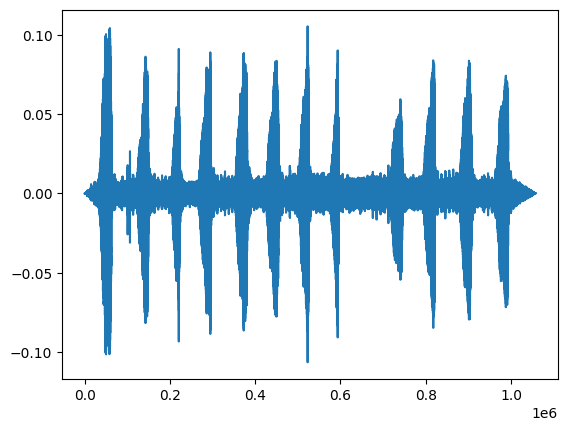

In [5]:
MFCC_COEF_RETAIN     = 25
MFCC_COEF            = 40
MFCC_WINDOW_DURATION = 0.0232 # in miliseconds
#OPTIMIZER            = keras.optimizers.Adam()

sr = 32000
filename = "train_audio\gyhbus1\XC446052.ogg"

audio, sr1 = librosa.load(filename, sr=32000)
plt.plot(audio)



[[-596.9327 -596.9327 -596.9327 ... -596.9327 -596.9327 -596.9327]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]


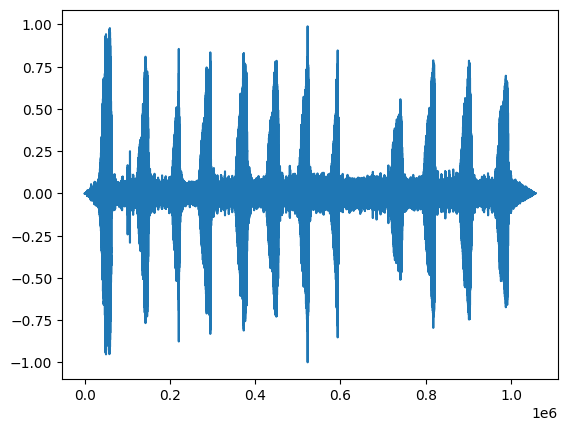

In [6]:
wave = librosa.util.normalize(audio)
plt.plot(wave)
mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=MFCC_COEF, hop_length=int(MFCC_WINDOW_DURATION*sr/2.0), n_fft=int(MFCC_WINDOW_DURATION*sr))
print(mfccs)

In [7]:
def get_mfcc(filename):
    sr = 32000
    MFCC_COEF = 40
    
    filename = filename
    
    #read ogg file
    audio, sr1 = librosa.load(filename, sr=32000)
    wave = librosa.util.normalize(audio)
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=MFCC_COEF, hop_length=int(MFCC_WINDOW_DURATION*sr/2.0), n_fft=int(MFCC_WINDOW_DURATION*sr))
    
    # standardise the coefficients
    mfccs = (mfccs - np.mean(mfccs))/np.std(mfccs)
    
    # keep the first MFCC_COEF_RETAIN coefficients
    mfccs = mfccs[:MFCC_COEF_RETAIN,:]
    
    # calculate MFCC statistics
    mfccs_min      = mfccs.min(axis=1)
    mfccs_max      = mfccs.max(axis=1)
    mfccs_median   = np.median(mfccs, axis=1)
    mfccs_mean     = np.mean(mfccs, axis=1)
    mfccs_var      = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)
    mfccs_mad      = median_abs_deviation(mfccs, axis=1)
    
    mfccs_first_derivative  = np.diff(mfccs, n=1, axis=1)    
    mfccs_first_derivative_mean = np.mean(mfccs_first_derivative, axis=1)
    mfccs_first_derivative_var  = np.var(mfccs_first_derivative, axis=1)
    
    mfccs_second_derivative = np.diff(mfccs, n=2, axis=1)
    mfccs_second_derivative_mean = np.mean(mfccs_second_derivative, axis=1)
    mfccs_second_derivative_var  = np.var(mfccs_second_derivative, axis=1)
    
    mfccs_stats = np.vstack((mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_var, mfccs_skewness, mfccs_kurtosis, mfccs_mad, mfccs_first_derivative_mean, mfccs_first_derivative_var, mfccs_second_derivative_mean, mfccs_second_derivative_var))
    
    
    return pd.Series([mfccs_stats.transpose()])            

In [12]:
import math
#finding average of number of labels
avg = math.ceil(metadata['primary_label'].value_counts().aggregate('average'))
#unique labels
primary_labels = metadata['primary_label'].unique()

mfcc1 = []
labels1 = []

#looping through labels
for label in tqdm(primary_labels):
    #subsetting dataframe by labels
    rows = metadata[metadata['primary_label'] == label]
    #checking if number of rows are greater than average 
    if(len(rows) >= avg):
        #looping through subsetted average number of rows
        for index, row in rows.iloc[0:avg].iterrows():
            path = os.getcwd() + "//train_audio/" + row['filename']
            #sounds_df[['mfccs_stats']]= sounds_df[['path']].progress_apply(lambda x: get_mfcc(*x), axis=1)
            mfccs = get_mfcc(path) # make dataset1
            mfcc1.append(mfccs)
            labels1.append(label)
    #if less than average then take all rows
    else:
        for index, row in rows.iterrows():
            path = os.getcwd() + "//train_audio/" + row['filename']
            #sounds_df[['mfccs_stats']]= sounds_df[['path']].progress_apply(lambda x: get_mfcc(*x), axis=1)
            mfccs = get_mfcc(path) # make dataset1
            mfcc1.append(mfccs)
            labels1.append(label)

65


  0%|          | 0/264 [00:00<?, ?it/s]

In [8]:
# for i in (len(filenames)):
#     path = os.join(os.getcwd()+filename[i]) # file parsing
#     df_mfccs = get_mfcc(path) # make dataset

from tqdm.notebook import tqdm

# add MFCCs and statistics to the data frame
#tqdm.pandas()

mfcc = []
labels = []
for index, row in tqdm(metadata.iterrows()):
    path = os.getcwd() + "//train_audio/" + row['filename']
    #sounds_df[['mfccs_stats']]= sounds_df[['path']].progress_apply(lambda x: get_mfcc(*x), axis=1)
    mfccs = get_mfcc(path) # make dataset1
    mfcc.append(mfccs)
    labels.append(row['primary_label'])

0it [00:00, ?it/s]

In [ ]:
print(len(audios)) 
print(len(labels)) 

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2)
tsne_model = model.fit_transform(x)

In [ ]:
!pip install ipywidgets